In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../../')

In [2]:
from pyexp.transform.periodic_splines import add_periodic_splines
from pyexp.transform.fracdiff import fracdiff

setattr(pd.Series, 'fracdiff', fracdiff)

## Motivation

Periodicity is frequently observed in time series applications. Below we fit a periodic signal in the mean in a linear model framework by using periodic splines. This is an alternative to the more common modeling by a categorical regressor. E.g., below we will show how to fit monthly data with annual periodicity with a regressor that of smaller dimension than 12.

## Example: monthly car registration numbers

In [3]:
cars = pd.read_csv('../../rawdata/macro/car_registrations.csv')
cars.month = pd.to_datetime(cars.month)
cars = cars.sort_values('month')
print(cars.head())
cars.set_index('month').plot(figsize=(12,4))

         month  neuzulassungen
168 2005-01-01             201
167 2005-02-01             220
166 2005-03-01             335
165 2005-04-01             313
164 2005-05-01             304


Note that the numbers look not only periodic but also show up some other long-term instationarity in the mean. Since the focus here is on periodicity, we remove part of the long-term instationarity by considering fractional differnces instead.

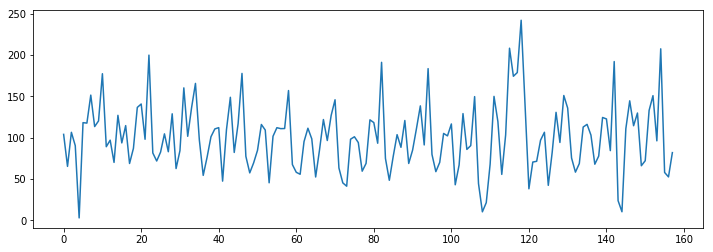

In [4]:
cars.neuzulassungen = cars.neuzulassungen.fracdiff(0.3)
cars.neuzulassungen.plot(figsize=(12,4))

## Construct the regressor

The complexity of the periodic curve is controlled by input `degrees_of_freedom`. Here we select a rather small number of 4. Choosing larger numbers results in more complex models. As always, we have to deal here with a bias-variance tradeoff.

In the implementation we use the periodicity time is rescaled to $[0,1]$.

In [5]:
cars['period'] = cars.month.dt.month/12

splines_df = 4
cars = add_periodic_splines(cars, 'period', degrees_of_freedom=splines_df)
cars.tail()

month  neuzulassungen  spline_score_1  spline_score_2  spline_score_3  \
4 2018-09-01        2.746848        0.005387       -0.166733        0.363286   
3 2018-10-01       90.277699       -0.152911       -0.103734       -0.189794   
2 2018-11-01      106.444551       -0.440519       -0.231517       -0.428225   
1 2018-12-01       65.173696       -0.401211       -0.401211       -0.401211   
0 2019-01-01      103.951081       -0.401211       -0.401211       -0.401211   

   spline_score_4  
4        0.710598  
3        0.856583  
2        0.243519  
1       -0.401211  
0       -0.401211

In [6]:
horizon = 24
fc_dates = pd.date_range(start = cars['month'].max()+pd.Timedelta('31 days'), periods=horizon, freq='MS')
fc_cars = pd.DataFrame({'month': fc_dates})
fc_cars['period'] = fc_cars.month.dt.month / 12
fc_cars = add_periodic_splines(fc_cars, 'period', degrees_of_freedom=splines_df)
fc_cars.head()

month  spline_score_1  spline_score_2  spline_score_3  spline_score_4
0 2019-02-01        0.240737       -0.431006       -0.234298       -0.443301
1 2019-03-01        0.854377       -0.192000       -0.105940       -0.155117
2 2019-04-01        0.708620        0.361308       -0.168711        0.003409
3 2019-05-01        0.100478        0.848719       -0.193218       -0.045687
4 2019-06-01       -0.252014        0.742453        0.181358       -0.202837

## Fit and predict a linear model

In [7]:
import statsmodels.formula.api as smf

In [8]:

formula = 'neuzulassungen ~ ' + ' + '.join(cars.columns[2:])
lm = smf.ols(formula=formula, data=cars).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         neuzulassungen   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     24.37
Date:                Fri, 21 Jun 2019   Prob (F-statistic):           1.29e-15
Time:                        08:14:31   Log-Likelihood:                -772.77
No. Observations:                 158   AIC:                             1556.
Df Residuals:                     153   BIC:                             1571.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        100.3791      2.603     38.556      0.000      95.236     105.522
spline_score_1    45.8559      6.539      7.012      0.000      32.937      58.775
spline_score_2    33.3343      6.404      5.205      0.000      20.683      45.986
spline_score_3   -15.1420      6.404     -2.364      0.019     -27.794      -2.490
spline_score_4    18.2917      6.539      2.797      0.006       5.373      31.210
==============================================================================
Omnibus:                        5.718   Durbin-Watson:                   2.136
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                6.681
Skew:                           0.245   Prob(JB):                       0.0354
Kurtosis:                       3.880   Cond. No.                         2.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
fc_cars['pred'] = lm.predict(fc_cars)

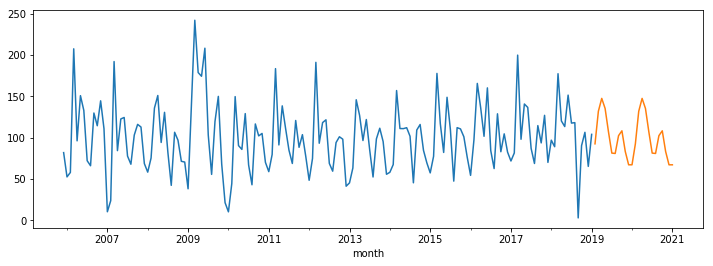

In [10]:
cars.set_index('month')['neuzulassungen'].plot(figsize=(12,4))
fc_cars.set_index('month')['pred'].plot(figsize=(12,4))